In [1]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


# Import Libraries

In [53]:
# import libraries
import warnings
warnings.filterwarnings('ignore')
import re
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import nltk 
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn import model_selection, svm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
pd.set_option('max_colwidth',99999)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Load the Data

In [10]:
path = '/content/drive/My Drive/capstone_project/Data/'
amazon_df = pd .read_csv(path+ 'amazon_cells_labelled.txt', delimiter='\t', names = ['customer_reviews', 'label'])
yelp_df =  pd .read_csv(path + 'yelp_labelled.txt', delimiter='\t', names = ['customer_reviews', 'label'])
imdb_df =  pd .read_csv(path + 'imdb_labelled.txt', delimiter='\t', names = ['customer_reviews', 'label'])
final_data = pd.concat([amazon_df,imdb_df,yelp_df])
final_data.head(10)

,customer_reviews,label
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1
5,I have to jiggle the plug to get it to line up...,0
6,If you have several dozen or several hundred c...,0
7,If you are Razr owner...you must have this!,1
8,"Needless to say, I wasted my money.",0
9,What a waste of money and time!.,0


In [11]:
final_data.shape

(2748, 2)

In [15]:
final_data.dtypes

customer_reviews    object
label                int64
dtype: object

## Checking for Missing values

In [12]:
final_data.isnull().sum()

customer_reviews    0
label               0
dtype: int64

# Distribution of traget column

In [14]:
final_data.label.value_counts()

1    1386
0    1362
Name: label, dtype: int64

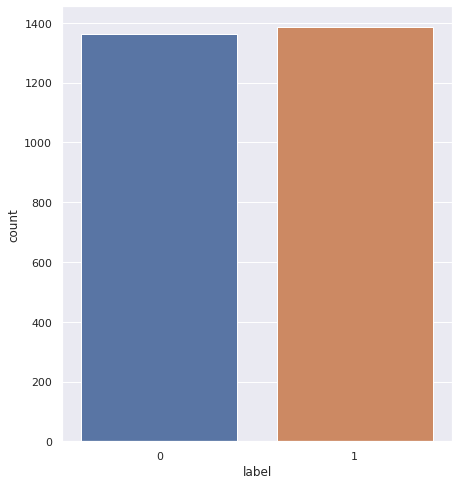

In [13]:
plt.figure(figsize=(7,8))
sns.set(style='darkgrid')
sns.countplot(x = 'label',
              data = final_data)
plt.show()

# Word Clouds

### Positive Reviews

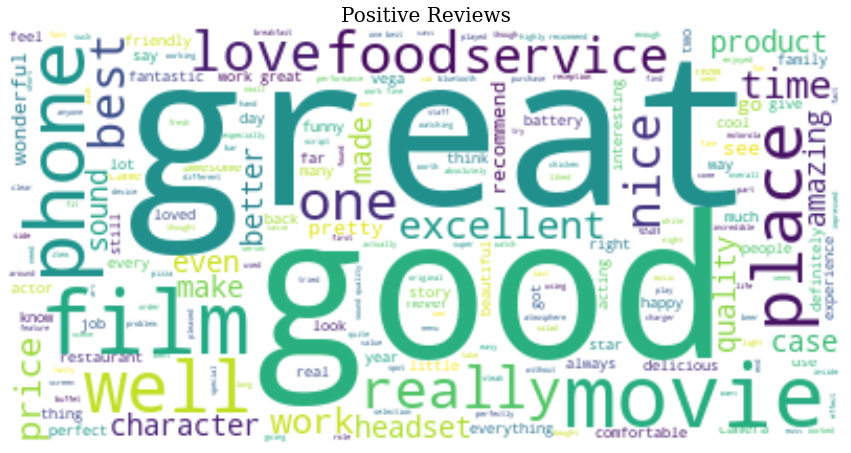

In [29]:
p_reviews = final_data[final_data.label == 1]
text_p = " ".join(review for review in  p_reviews['customer_reviews'])
stopwords = set(STOPWORDS)
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text_p)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize=[15,30])
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Positive Reviews', font1)
plt.axis("off")
plt.show()

### Negative Reviews

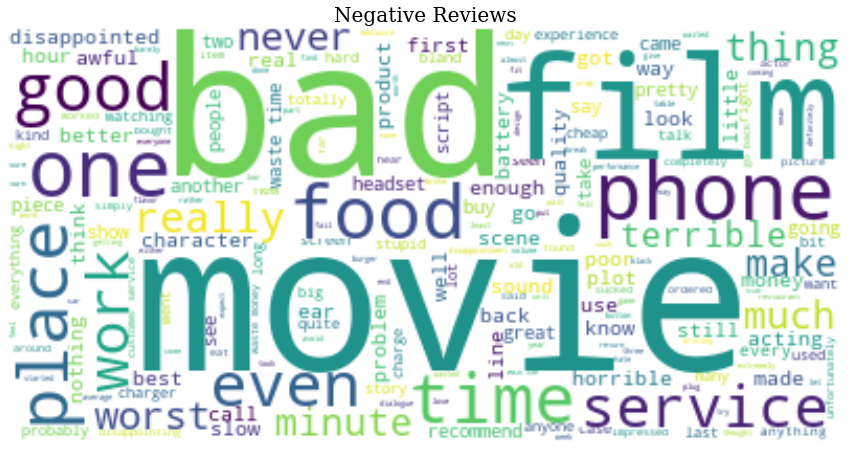

In [30]:
n_reviews = final_data[final_data.label == 0]
text_n = " ".join(review for review in  n_reviews['customer_reviews'])
stopwords = set(STOPWORDS)
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords,background_color="white").generate(text_n)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize=[15,30])
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Negative Reviews', font1)
plt.axis("off")
plt.show()

# Polarity

In [31]:
dff = final_data.copy()

In [32]:
dff['polarity']=dff['customer_reviews'].apply(lambda x:TextBlob(x).sentiment.polarity)

In [34]:
dff[dff['polarity']==1.0].head(10)

,customer_reviews,label,polarity
26,owned phone 7 month say best mobile phone,1,1.0
41,impressed product,0,1.0
44,excellent bluetooth headset,1,1.0
159,w810i superb,1,1.0
170,excellent service,1,1.0
194,impressed,0,1.0
236,best bluetooth market,1,1.0
246,excellent wallet type phone case,1,1.0
251,gosh best phone ever,1,1.0
265,battery life real good,1,1.0


In [35]:
dff[dff['polarity']==-1.0].head(10)

,customer_reviews,label,polarity
218,worst phone ever,0,-1.0
242,worst customer service ever,0,-1.0
298,customer service terrible,0,-1.0
344,worst customer service,0,-1.0
353,network coverage los angeles horrible,0,-1.0
373,worst phone ever month,0,-1.0
459,horrible phone,0,-1.0
526,horrible switch 3 time,0,-1.0
546,worst software ever used could give zero star ...,0,-1.0
572,worst ever,0,-1.0


# Data Cleaning

## Converting the text to lower case and handling spaces

In [16]:
final_data['customer_reviews']=final_data['customer_reviews'].apply(lambda x: x.replace('.', '. ').replace(',', ', ').replace(':', ': ').replace(';', '; '))
final_data['customer_reviews']=final_data['customer_reviews'].apply(lambda x: " ".join(x.lower() for x in x.split()))

## Removing special charcters and numbers

In [17]:
def clean(text):
    
    text = re.sub(r'[^A-Za-z0-9]+', ' ', text) 
    text = re.sub(r'https?:/\/\S+', ' ', text) 
    
    return text.strip()
final_data['customer_reviews']=final_data['customer_reviews'].apply(lambda x: clean(x))

# Removing stopwords

In [18]:
stop = nltk.corpus.stopwords.words('english')
def remove_stopwords(text):
    output= [i for i in text if i not in stop]
    return output

final_data['customer_reviews']=final_data['customer_reviews'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

## Tokenization

In [19]:
def tokenize(txt):
    return word_tokenize(txt)
final_data['customer_reviews']=final_data['customer_reviews'].apply(lambda x: tokenize(x))

# Lemmatization

In [20]:
#defining the object for Lemmatization
wordnet_lemmatizer = WordNetLemmatizer()
#defining the function for lemmatization
def lemmatizer(text):
  lemm_text = " ".join([wordnet_lemmatizer.lemmatize(word) for word in text])
  return lemm_text
final_data['customer_reviews']=final_data['customer_reviews'].apply(lambda x: lemmatizer(x))

# Train Test Split

In [38]:
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(final_data['customer_reviews'],final_data['label'],test_size=0.3,random_state = 42)

## Function to train machine learning classifier

In [42]:
def train_model(hyperparameters, x_train, y_train, x_test, y_test,classifier, k_fold = 10):
  ld = classifier()
  kfold = StratifiedKFold(n_splits=k_fold, shuffle=True, random_state=1)
  clf = GridSearchCV(ld, hyperparameters, cv=kfold)
  clf.fit(x_train, y_train)
  tst_pred = clf.predict(x_test)
  trn_pred =  clf.predict(x_train)
  trn_acc = accuracy_score(trn_pred, y_train)
  test_acc = accuracy_score(tst_pred, y_test)
  return trn_acc, test_acc, tst_pred

## Function to evaluate the perfomance of Machine learning model

In [43]:
def model_results(prediction, true):
  print(classification_report(prediction, true))
  cm = confusion_matrix(prediction, true)
  #Evaluating the performance of the model 
  plt.figure(figsize = (7,3))
  ax= plt.subplot()
  sns.heatmap(cm, annot=True,fmt="d", annot_kws={"size": 16},ax = ax); #annot=True to annotate cells
  ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
  ax.set_title('Confusion Matrix')
  

# Feature Extraction

## Bag of Words

In [39]:
cv = CountVectorizer()
bow_x_train = cv.fit_transform(Train_X)
bow_x_test  = cv.transform(Test_X)

# TF-IDF

In [44]:
Tfidf_vect = TfidfVectorizer()
Train_X_Tfidf = Tfidf_vect.fit_transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

# Logistic Regression

## Logistic Regression with Bag of words

Train Accuracy: 0.9027561102444098 | Test Accuracy: 0.7733333333333333
              precision    recall  f1-score   support

           0       0.80      0.78      0.79       444
           1       0.75      0.77      0.76       381

    accuracy                           0.77       825
   macro avg       0.77      0.77      0.77       825
weighted avg       0.77      0.77      0.77       825



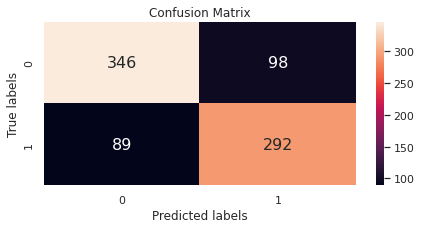

In [49]:
penalty = ['l1', 'l2']
c = [0.01,0.02, 0.03, 0.05, 0.1]
hypes = dict(C=c, penalty=penalty)
train_accuracy1, test_accuracy1, test_prediction1 = train_model(hypes,bow_x_train,Train_Y, bow_x_test, Test_Y, LogisticRegression, k_fold = 10)
print("Train Accuracy: {} | Test Accuracy: {}".format(train_accuracy1,test_accuracy1))
model_results(test_prediction1, Test_Y)

## Logistic Regression with TF-IDF

Train Accuracy: 0.8772750910036401 | Test Accuracy: 0.7515151515151515
              precision    recall  f1-score   support

           0       0.64      0.85      0.73       330
           1       0.87      0.69      0.77       495

    accuracy                           0.75       825
   macro avg       0.76      0.77      0.75       825
weighted avg       0.78      0.75      0.75       825



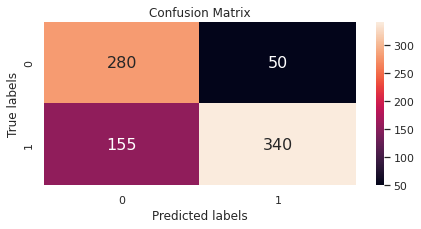

In [50]:
train_accuracy2, test_accuracy2, test_prediction2 = train_model(hypes,Train_X_Tfidf,Train_Y, Test_X_Tfidf, Test_Y, LogisticRegression, k_fold = 10)
print("Train Accuracy: {} | Test Accuracy: {}".format(train_accuracy2,test_accuracy2))
model_results(test_prediction2, Test_Y)

# SVM

## SVM with bag of words

Train Accuracy: 0.9568382735309412 | Test Accuracy: 0.7927272727272727
              precision    recall  f1-score   support

           0       0.80      0.81      0.80       428
           1       0.79      0.78      0.78       397

    accuracy                           0.79       825
   macro avg       0.79      0.79      0.79       825
weighted avg       0.79      0.79      0.79       825



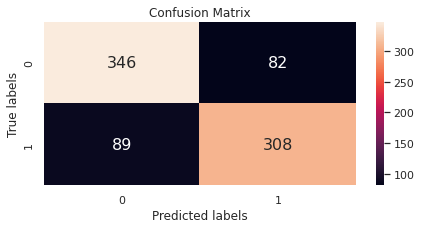

In [51]:
parameters = [{'C': [0.01,0.03,0.05, 0.1,0.3,0.5], 'kernel': ['linear']},{'C': [0.01,0.03,0.05, 0.1,0.3,0.5], 'kernel': ['rbf'], 'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}]
train_accuracy3, test_accuracy3, test_prediction3 = train_model(parameters,bow_x_train,Train_Y, bow_x_test, Test_Y, svm.SVC, k_fold = 10)
print("Train Accuracy: {} | Test Accuracy: {}".format(train_accuracy3,test_accuracy3))
model_results(test_prediction3, Test_Y)

## SVM with TF-IDF

Train Accuracy: 0.9370774830993239 | Test Accuracy: 0.7806060606060606
              precision    recall  f1-score   support

           0       0.78      0.80      0.79       424
           1       0.78      0.76      0.77       401

    accuracy                           0.78       825
   macro avg       0.78      0.78      0.78       825
weighted avg       0.78      0.78      0.78       825



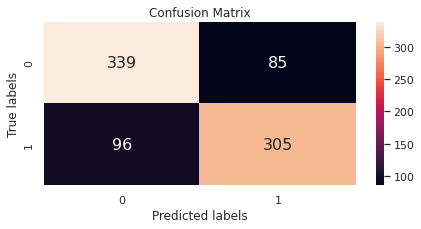

In [52]:
parameters = [{'C': [0.01,0.03,0.05, 0.1,0.3,0.5], 'kernel': ['linear']},{'C': [0.01,0.03,0.05, 0.1,0.3,0.5], 'kernel': ['rbf'], 'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}]
train_accuracy4, test_accuracy4, test_prediction4 = train_model(parameters,Train_X_Tfidf,Train_Y, Test_X_Tfidf, Test_Y, svm.SVC, k_fold = 10)
print("Train Accuracy: {} | Test Accuracy: {}".format(train_accuracy4,test_accuracy4))
model_results(test_prediction4, Test_Y)